# Imports, Fixed training pms, util fions


In [1]:
# imports
import os
import pickle
from copy import deepcopy
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.auto import tqdm
from time import time, sleep
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim
from sklearn.model_selection import KFold, StratifiedKFold

try:
  print("Path to Thesis =", ptt)
except:
  if "drive" in os.listdir():
    print("Working on GDrive.")
    ptt = ""
    %cd /content/drive/My\ Drive/Thesis/
  else:
    print("Working on local device.")
    ptt = os.path.expanduser("~/thesis")
    print("pathToThesis =", ptt)

from NNClasses import *
from NNDataLoader import *
from NN_train_util import *
from util import *

%load_ext autoreload
%autoreload 1
%aimport NNDataLoader
%aimport NN_train_util

# ----------------------------
# FIXED TRAINING PARAMETERS
# ----------------------------
early_stop_patience = 50
Tc0 = .894 #from "Critical behavior of the two-dimensional XYmodel", Gupta & Baillie, 1992
early_stopping_enabled = True # True  
criterion = nn.BCELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"torch device: {device}")

Working on GDrive.
/content/drive/My Drive/Thesis
torch device: cuda


In [2]:
def printTrainingPms():
  """Prints important pms for (current) training procedure.
  Includes: learning_rate, batch_size, epochs, early_stop_patience, cv_splits."""
  print()
  print("This training has parameters:")
  print(f"Learning rate = {learning_rate}.\nBatch size = {batch_size}.")
  print(f"During {epochs} epochs, with early stopping patience {early_stop_patience}.")
  print(f"While splitting the data in {cv_splits} splits.")

def printDataSetPms(data : CustomDataset):
  """Prints data set pms.:
  L, size, Tc and state"""
  print(f"\nData loaded of size L={data.L} with {len(data)} samples.\nCritical temperature Tc={data.Tc}.\nTraining on {data.state}.")


def save_intermittent_data(imd_arr, L_id, fold_id, epoch_id, sample_id, num_samples_batch, model):
  """Save intermittent data for customNN"""
  # save intermittent data
  if model.name == "CustomNN" and model.save_intermittent:
    imd_arr[L_id, fold_id, epoch_id, sample_id:sample_id+num_samples_batch,:,:] = model.intermediate_data
  else:
    print(f"Trying to save intermittent data on the model {model.longname()}, but model does not have it enabled.")

# Data set analysis

## Distribution of labels

In [ ]:
if False:
  # load dumped datasets
  train_data = load_data_from_pickle(L, Tc0, pathToThesis=ptt, trainSet=True, train_on_vortex=False)

  L_range = [_ for _ in range(8,64+1,8)]
  for L_ in L_range:
      classes_labels = np.array([0,1])
      classes = train_data.labels.int().squeeze().bincount().cpu()

      print(f"Class distribution: {100*(classes[0]/classes.sum()):.2f}% / {100*(classes[1]/classes.sum()):.2f}%")
      width=1
      fig, ax = plt.subplots()

      ax.bar(classes_labels, classes/classes.sum()*100, width-.1, label="class distribution")
      ax.set_xticks(classes_labels)
      ax.set_ylabel(f"Percentage (of {classes.sum()} samples)")
      ax.set_xlabel("Classes")
      ax.set_title(f"Class distribution of configurations of size {L_}")
      plt.show()
      break

## Compare normalized spin to vortex and raw spin to vortex values

Should be equal. If not, round the number (or the number causing the problem).

In [ ]:
if False:
  # ONLY RUNS IF USING HIGH RAM (for L=56,64)
  # compare vortex data from data with normalized data, should be equal
  L_range = [8,16,24,32,40,48,56,64]
  for L in L_range:
    print(L,":")
    train_data = load_data_from_pickle(L, Tc0, pathToThesis=ptt, trainSet=True, train_on_vortex=False)
    cfgs = deepcopy(train_data)
    for i in range(1000):
      size = len(train_data) // 1000
      cfgs.configs = cfgs.configs[i*size:(i+1)*size]
      cfgs.Ts = cfgs.Ts[i*size:(i+1)*size]
      cfgs.labels = cfgs.labels[i*size:(i+1)*size]
      cfgs.to("cuda")
      

      norm_data = deepcopy(cfgs)
      norm_data.normalize_data()


      
      cfgs.spin_to_vortex()
      norm_data.spin_to_vortex() 
      #vortices are always normalized

      # find unequal values
      #print("equal: ",np.count_nonzero((cfgs.configs - norm_data.configs < 1e-5).cpu().numpy()))
      idcs = np.nonzero((cfgs.configs - norm_data.configs > 1e-5).cpu().numpy())
      if idcs[0].any():
        # print the values
        print("wrong samples:", idcs)
        #print("cfgs:", cfgs.configs[idcs].item(), "\tnorm_data:", norm_data.configs[idcs].item())
        cfgs = load_data_from_pickle(L, Tc0, pathToThesis=ptt, trainSet=True, train_on_vortex=False)
        cfgs.configs.unsqueeze_(1)
        for i in range(len(idcs[0])):
          problem_number = cfgs.configs[idcs[0][i], idcs[1][i], idcs[2][i], idcs[3][i]].item()
          print(f"problem {i+1} @ [{idcs[0][i]},{ idcs[1][i]},{ idcs[2][i]},{ idcs[3][i]}]:", problem_number)

          # round number
          if L == 24:
            problem_number *= .0
            print(f"hardly changed {i+1}:", problem_number)
            problem_nr_2 = cfgs.configs[idcs[0][i], idcs[1][i], idcs[2][i]+1, idcs[3][i]+1].item()
            problem_nr_2 =  round(problem_nr_2 * 1e5) / 1e5
            print("maybe this:", problem_nr_2)
            cfgs.configs[idcs[0][i], idcs[1][i], idcs[2][i]+1, idcs[3][i]+1] = problem_nr_2
            
          problem_number =  round(problem_number * 1e5) / 1e5
          print(f"rounded L={L} {i+1}:", problem_number)
          
          # replace number
          cfgs.configs[idcs[0][i], idcs[1][i], idcs[2][i], idcs[3][i]] = problem_number

        # all numbers replaced, check if good now
        #"""
        cfgs.configs.squeeze_(1)
        norm_data = deepcopy(cfgs)
        norm_data.normalize_data()

        cfgs.spin_to_vortex()
        norm_data.spin_to_vortex() 

        print(f"AFTER FIX, L={L} equal: ",np.count_nonzero((cfgs.configs - norm_data.configs < 1e-5).cpu().numpy()))

        idcs = np.nonzero((cfgs.configs - norm_data.configs > 1e-5).cpu().numpy())
        if idcs[0].any():
          # print the values
          print("wrong samples AGAIN:", idcs)
        """
        # save the data again (raw data configs obv)
        f = get_filename(L)
        print(f)
        with open(f, "wb") as file:
          pickle.dump(cfgs, file)
        """
    print("---")
    

## Distribution of values of dataset

Distribution of raw spin angles or (processed) vortices.

In [ ]:
if False:
  L_range = [8,16,32,64]
  L = 8
  train_set_bool = True
  vortices_bool = False

  # fig, ax = plt.subplots()
  for L in L_range[::-1]:
    train_data = load_data_from_pickle(L, Tc0, pathToThesis=ptt, trainSet=train_set_bool, train_on_vortex=vortices_bool, device = device)
    plot_torch_distr(train_data.configs)
    """
    data, edges = torch.histogram(train_data.configs, bins=25, density=False)
    l_e = edges[:-1]
    w = (l_e[1] - l_e[0])
    ax.bar(l_e, data, align='edge', width=w, label=L, alpha=0.5)
    """
    #train_data.spin_to_vortex()
    #fig, ax = plt.subplots()
    #data, edges = torch.histogram(train_data.configs, bins=25, density=False)
    #l_e = edges[:-1]
    #w = (l_e[1] - l_e[0])
    #ax.bar(l_e, data, align='edge', width=w, label=L, alpha=0.5)
  ax.legend()
    


# Simple Training



## Training Loop


['LongerRun_CustomNN_randomInit']
Data normalized.

This training has parameters:
Learning rate = 0.0005.
Batch size = 10.
During 250 epochs, with early stopping patience 50.
While splitting the data in 10 splits.

Data loaded of size L=8 with 64000 samples.
Critical temperature Tc=0.894.
Training on spin angles.
Now training on  spin angles


Epochs (fold 1/10): 100%|██████████| 250/250 [59:21<00:00, 14.24s/it]


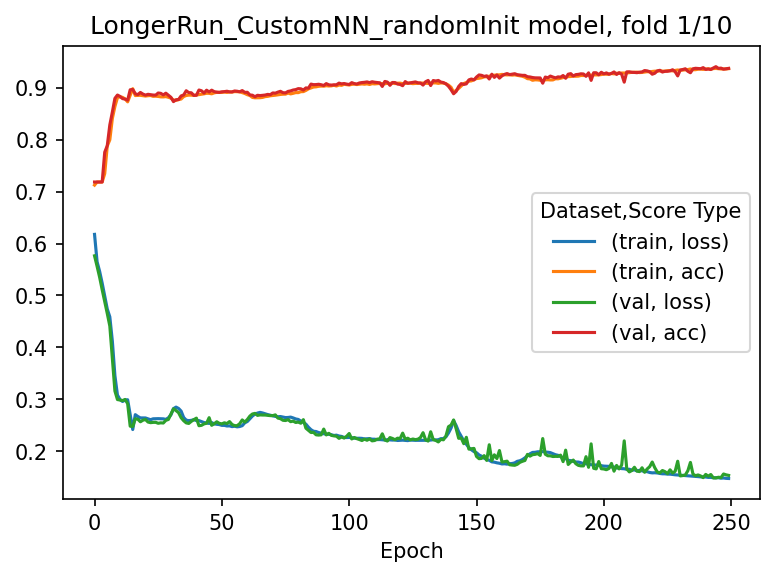

Model data saved after fold  1 .
Deleting scores of fold 1


Epochs (fold 2/10): 100%|██████████| 250/250 [59:34<00:00, 14.30s/it]


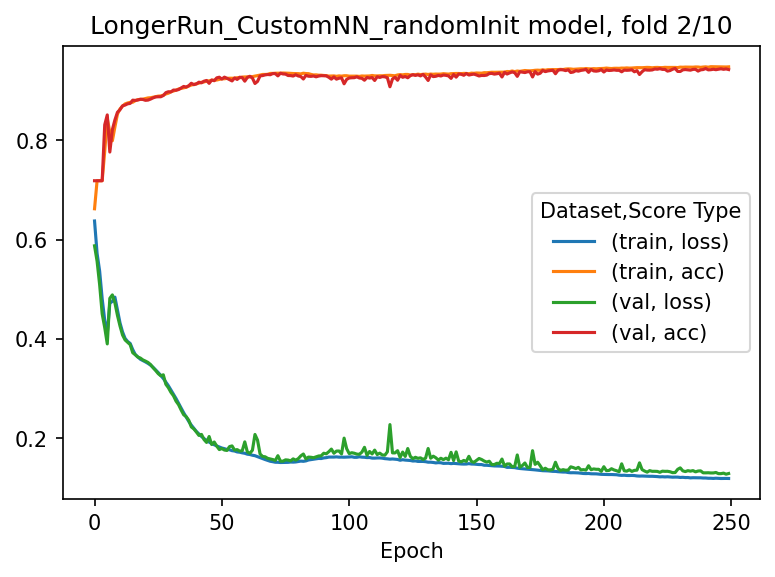

Model data saved after fold  2 .
Deleting scores of fold 2


Epochs (fold 3/10): 100%|██████████| 250/250 [1:00:00<00:00, 14.40s/it]


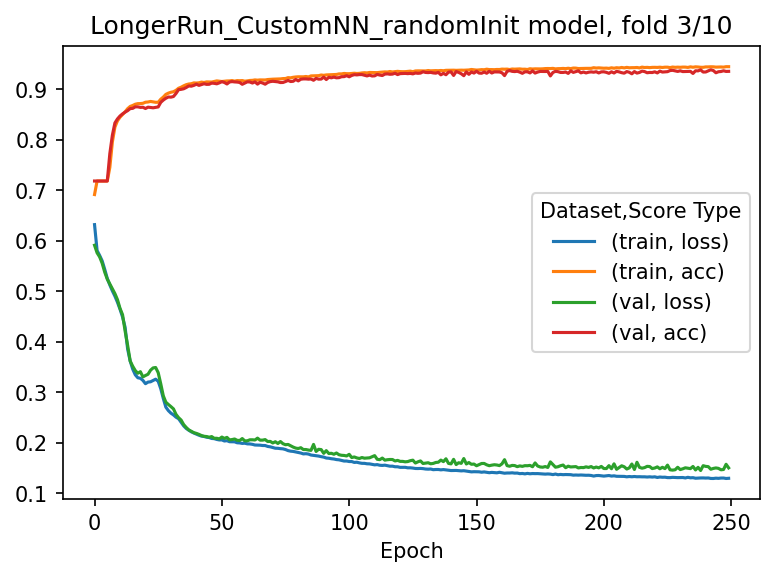

Model data saved after fold  3 .
Deleting scores of fold 3


Epochs (fold 4/10): 100%|██████████| 250/250 [1:00:03<00:00, 14.41s/it]


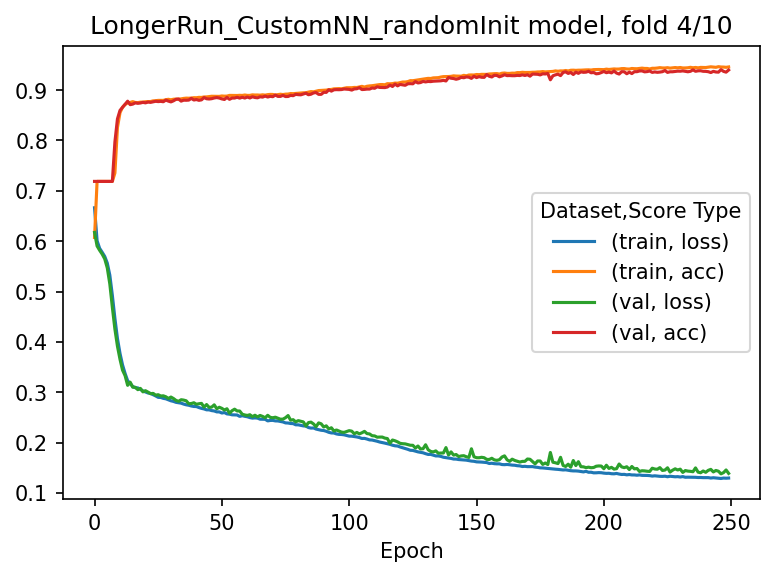

Model data saved after fold  4 .
Deleting scores of fold 4


Epochs (fold 5/10): 100%|██████████| 250/250 [1:00:10<00:00, 14.44s/it]


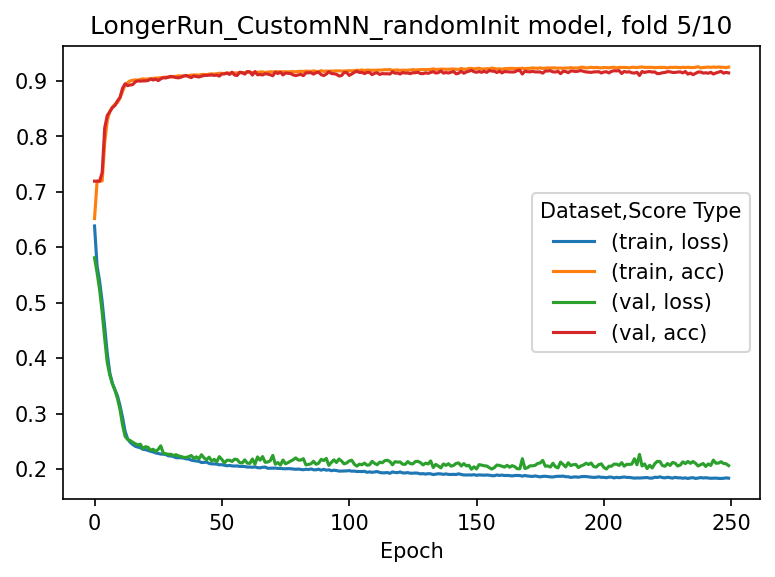

Model data saved after fold  5 .
Model LongerRun_CustomNN_randomInit, fold 4. Best loss and accuracy (last fold): nan and nan
(1500, 4)
['LongerRun_CustomNN_randomInit']
Data normalized.

This training has parameters:
Learning rate = 0.0005.
Batch size = 10.
During 250 epochs, with early stopping patience 50.
While splitting the data in 10 splits.

Data loaded of size L=32 with 64000 samples.
Critical temperature Tc=0.894.
Training on spin angles.
Now training on  spin angles


Epochs (fold 1/10): 100%|██████████| 250/250 [1:02:16<00:00, 14.95s/it]


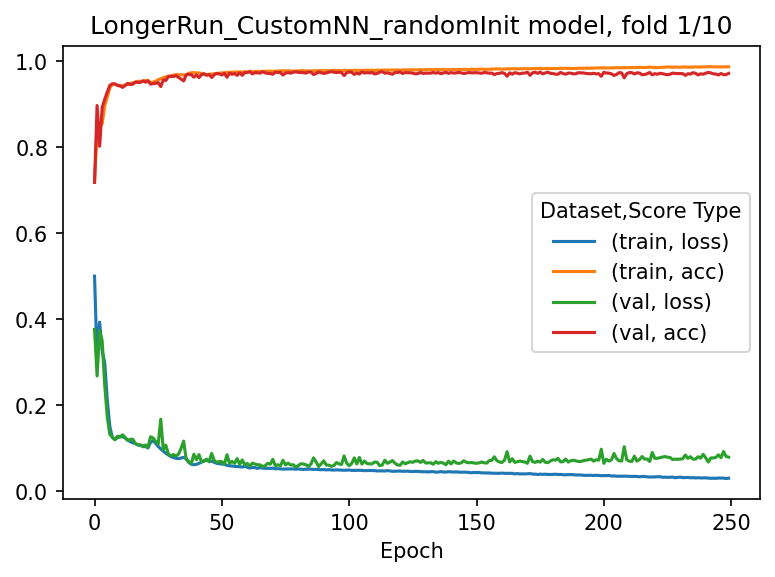

Model data saved after fold  1 .
Deleting scores of fold 1


Epochs (fold 2/10): 100%|██████████| 250/250 [1:02:12<00:00, 14.93s/it]


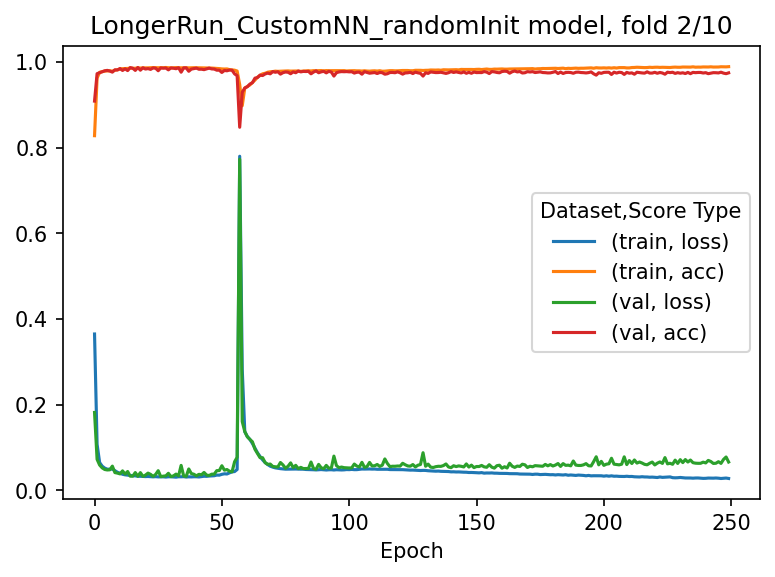

Model data saved after fold  2 .
Deleting scores of fold 2


Epochs (fold 3/10): 100%|██████████| 250/250 [1:02:15<00:00, 14.94s/it]


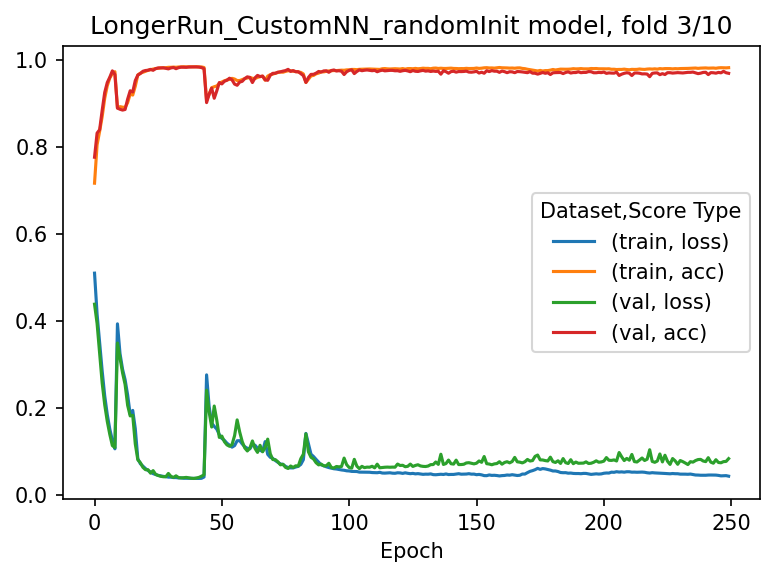

Model data saved after fold  3 .
Deleting scores of fold 3


Epochs (fold 4/10): 100%|██████████| 250/250 [1:02:09<00:00, 14.92s/it]


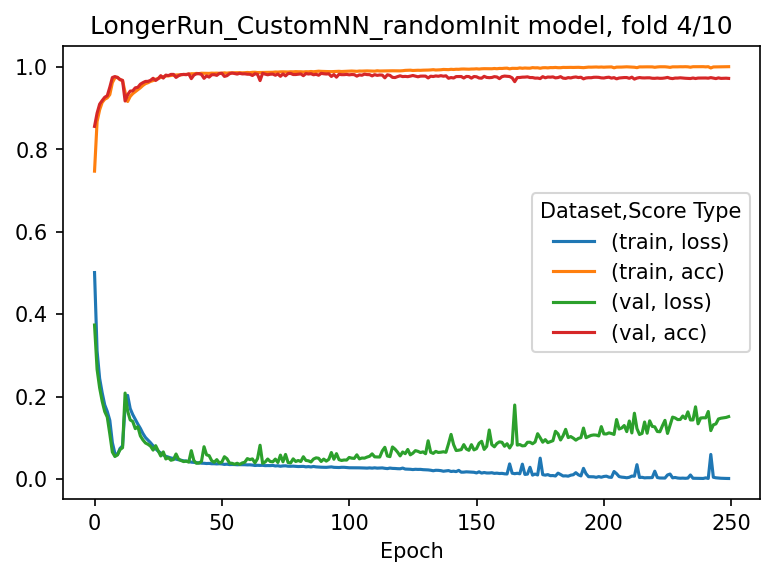

Model data saved after fold  4 .
Deleting scores of fold 4


Epochs (fold 5/10): 100%|██████████| 250/250 [1:02:16<00:00, 14.95s/it]


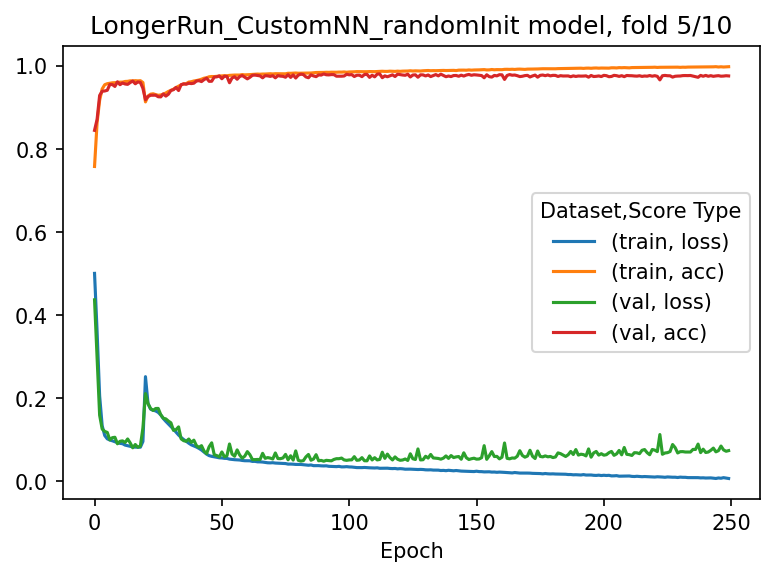

Model data saved after fold  5 .
Model LongerRun_CustomNN_randomInit, fold 4. Best loss and accuracy (last fold): nan and nan
(1500, 4)
['LongerRun_CustomNN_randomInit']
Data normalized.

This training has parameters:
Learning rate = 0.0005.
Batch size = 10.
During 250 epochs, with early stopping patience 50.
While splitting the data in 10 splits.

Data loaded of size L=64 with 64000 samples.
Critical temperature Tc=0.894.
Training on spin angles.
Now training on  spin angles


Epochs (fold 1/10): 100%|██████████| 250/250 [1:11:26<00:00, 17.15s/it]


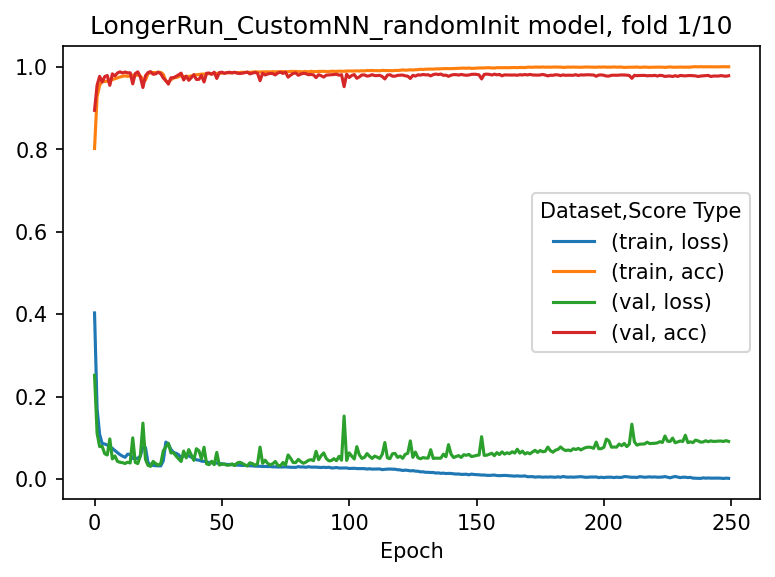

Model data saved after fold  1 .
Deleting scores of fold 1


Epochs (fold 2/10): 100%|██████████| 250/250 [1:11:03<00:00, 17.05s/it]


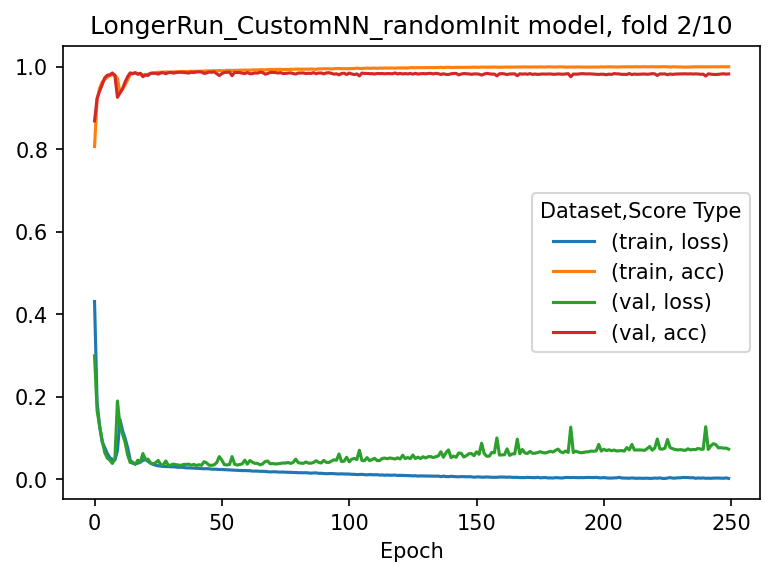

Model data saved after fold  2 .
Deleting scores of fold 2


Epochs (fold 3/10): 100%|██████████| 250/250 [1:11:09<00:00, 17.08s/it]


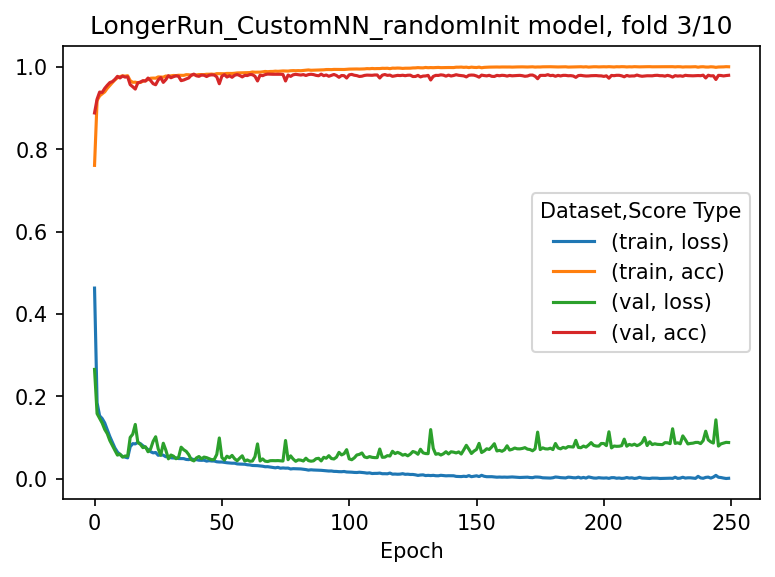

Model data saved after fold  3 .
Deleting scores of fold 3


Epochs (fold 4/10): 100%|██████████| 250/250 [1:11:12<00:00, 17.09s/it]


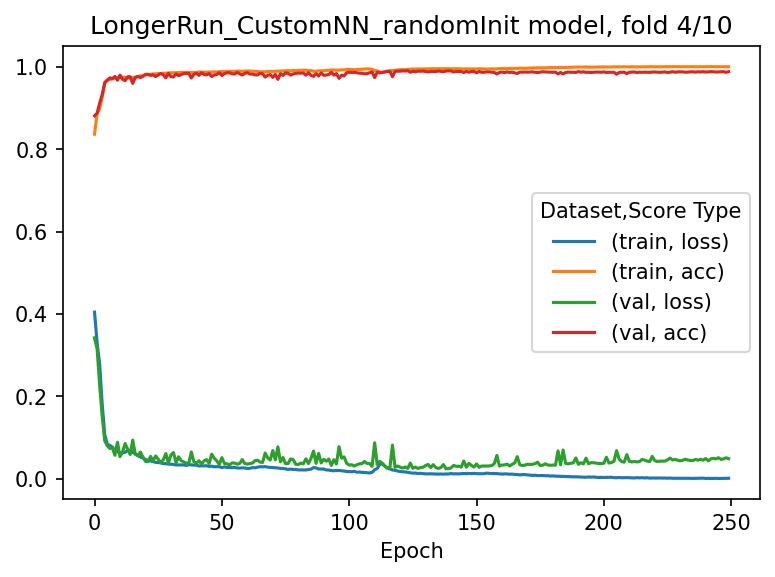

Model data saved after fold  4 .
Deleting scores of fold 4


Epochs (fold 5/10): 100%|██████████| 250/250 [1:11:11<00:00, 17.09s/it]


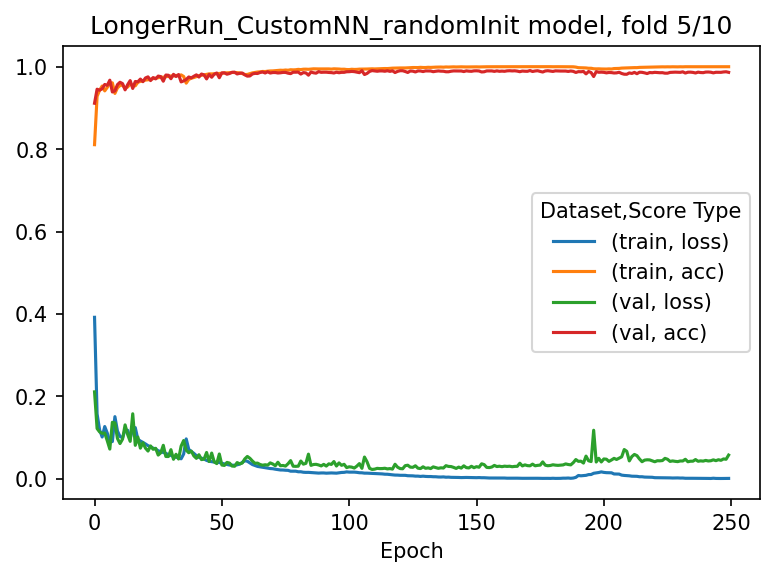

Model data saved after fold  5 .
Model LongerRun_CustomNN_randomInit, fold 4. Best loss and accuracy (last fold): nan and nan
(1500, 4)


In [3]:
# ----------------------------
# TRAINING PARAMETERS
# ----------------------------
epochs = 250          # 250
learning_rate = 5e-4  # 2e-3 CNN & 5e-3 FFNN # 2e-4 gave sudden shot up in performanc, not okay!!
batch_size = 10       # 10
cv_splits = 10        # 10, change this to determine size of validation set (=1 split)
only_do_x_fold = 5    # change this to limit training time (only train x models)
max_data_Size = 64000 # 64000 is max (64 x 1000)
train_on_vortex = False 
data_set_normalization = True # default=True
PREFIX = "LongerRun"
L_range = [8,32,64]        # [8,16,32,48,64]

custom_model_save_intermittent = False # whether to save intermittent data for CustomNN

# ----------------------------
# META TRAINING SETTINGS
# ----------------------------
early_stopping_enabled = False 
Step_lr_enabled = False # first 10 epochs are with 10x higher learning rate

step_lr_milestones = [10,50,100,200]
step_lr_factor = 1/2

last_model_on_vortices = False # ! temp
plot_every_fold = True # plot after every fold
save_model_every_fold = True # save model for each fold
print_scores = False # while running, print scores per epoch
save_scores_all_folds = False # save bests scores for every fold
keep_predictvslabel_inMem = False

# ----------------------------
# MODELS AND DATA
# ----------------------------

for L_id, L in enumerate(L_range):
  # CNN(L, normalized_data_bool=data_set_normalization, device=device)
  # FFNN(L, normalized_data_bool=data_set_normalization, device=device)
  # Custom(L, vortexInit=True ,save_intermittent=custom_model_save_intermittent, normalized_data_bool=data_set_normalization, device=device)
  
  # # FFNN vs CNN
  # models = [FFNN(L, normalized_data_bool=data_set_normalization), CNN(L, normalized_data_bool=data_set_normalization)] 
  
  #models = [Custom(L, vortexInit=True ,save_intermittent=custom_model_save_intermittent, normalized_data_bool=data_set_normalization)]
  models = [Custom(L, vortexInit=False ,save_intermittent=custom_model_save_intermittent, normalized_data_bool=data_set_normalization, device=device)]
  


  # DataFrame
  modelnames = [model.longname() for model in models] # default values, can be specified if needed
  if train_on_vortex: # add _vortices to name if needed
    modelnames = [name + "_vortices" for name in modelnames]
  modelnames = [PREFIX + "_" + name for name in modelnames]
  print(modelnames)

  scoreDataTypes = ["train", "val"]
  scoreTypes = ["loss", "acc"]
  col_list = pd.MultiIndex.from_product([scoreDataTypes, scoreTypes], names=["Dataset", "Score Type"])
  row_list = pd.MultiIndex.from_product([modelnames, range(cv_splits), range(epochs)], names=["Model","Fold", "Epoch"])
  all_scores = pd.DataFrame(index=row_list, columns=col_list)

  # ----------------------------
  # TRAINING LOOP
  # ----------------------------
  training_loop_id = f"{time():0.0f}"

  # load data
  train_data = load_data_from_pickle(L, Tc0, pathToThesis=ptt, trainSet=True, train_on_vortex=train_on_vortex, device="cpu")
  train_data.max_size = len(train_data)
  train_data.shortenData(max_data_Size)
  train_data.set_type("binary")
  train_data.to("cpu")

  if data_set_normalization:
    train_data.normalize_data()

  # set model on cuda if available (?)
  if torch.cuda.is_available():
    for model in models:
      model.cuda()

  # print some pms
  printTrainingPms()
  printDataSetPms(train_data)

  # train all models
  for model_id, model in enumerate(models):
      # if model_id+1 == len(models) and last_model_on_vortices: # last model
      #   train_data.spin_to_vortex()
      print("Now training on ", train_data.state)

      # K fold CV 
      Kfold = StratifiedKFold(n_splits=cv_splits, shuffle=True) # stratified or not

      
      if keep_predictvslabel_inMem:
        # lists of (predictions, labels) per epoch_id per fold_id
        outputvsprediction_data = []

      num_samples_total = len(train_data)


      # loop over folds for one model
      for fold_id, (train_ids, val_ids) in enumerate(Kfold.split(train_data.configs, train_data.labels)):
          if keep_predictvslabel_inMem:
            # begin of fold: add new empty list to append to
            outputvsprediction_data.append([])

          # intermittend data
          if custom_model_save_intermittent:
            imd = np.empty((len(L_range), only_do_x_fold, epochs, len(train_ids), L, L))

          # define data loaders in this fold
          train_sampler = SubsetRandomSampler(train_ids)
          val_sampler = SubsetRandomSampler(val_ids)

          train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
          val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)
          
          num_samples_fold = len(train_loader) # amount of batches, train data
          num_samples_fold_val = len(val_loader) # amount of batches, val data

          # reset model every fold
          model = model.apply(lambda m : reset_weights(m, silence=True))
          best_val_loss = 1000
          best_model = deepcopy(model)

          # init optim
          optimizer = optim.SGD(model.parameters(), lr=learning_rate)

          # init scheduler if enabled
          if Step_lr_enabled:
            print(f"Learning rate x{step_lr_factor} after epochs {step_lr_milestones}.")
            lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=step_lr_milestones, gamma=step_lr_factor)

          if print_scores:
              print(f"Fold    Epoch    Train_loss    Validate_loss    Train_acc    Validate_acc")
          # train with this split
          for epoch_id, epoch in tqdm(enumerate(range(epochs)), desc=f"Epochs (fold {fold_id+1}/{cv_splits})", total=epochs):
              epoch_loss = 0
              epoch_accuracy = 0

              if keep_predictvslabel_inMem:
                  # begin of epoch: add new empty list to append to
                  outputvsprediction_data[fold_id].append([])
              
              # intermittent data aux
              if custom_model_save_intermittent:
                  sample_id = 0 # keep track of which sample, 0..len(data)

              # loop over all training data
              model.train()
              for data, label in train_loader:
                  num_samples_batch = len(data)
                  data = data.to(device)
                  label = label.to(device).float().view((num_samples_batch,1))
                  
                  output = model(data)

                  batch_loss = criterion(output, label)

                  optimizer.zero_grad() # reset accumulation of gradients
                  batch_loss.backward() # grad calc for all pms who req grad
                  optimizer.step() # updates pms
                  
                  # threshold value of 0.5 to determine class.
                  batch_acc = ((output > 0.5).float() == label).float().mean()
                  epoch_accuracy += batch_acc.item() / num_samples_fold
                  epoch_loss += batch_loss.item() / num_samples_fold
                  
                  if keep_predictvslabel_inMem:
                      # SAVE PREDICTION VS LABEL DATA
                      # add temp data to temp nested list
                      outputvsprediction_data[fold_id][epoch_id].append((output, label))

                  # save intermittent data
                  if custom_model_save_intermittent and epoch_id % 10 == 0:
                      save_intermittent_data(imd, L_id, fold_id, epoch_id, sample_id, num_samples_batch, model)
                      sample_id += num_samples_batch

              # validate loop
              model.eval()
              with torch.no_grad(): # no_grad disables gradient calcs
                  epoch_val_accuracy = 0
                  epoch_val_loss = 0
                  
                  for data, label in val_loader:
                      data = data.to(device)
                      label = label.to(device).float().view((label.shape[0], 1))

                      val_output = model(data)
                      val_loss = criterion(val_output, label)
                      acc = ((val_output > 0.5).float() == label).float().mean().item()
                      epoch_val_accuracy += acc / num_samples_fold_val
                      epoch_val_loss += val_loss.item() / num_samples_fold_val
              
              if print_scores:
                  print(f"{fold_id+1: 5}   {epoch_id+1: 5}    {epoch_loss:.4f}        {epoch_val_loss:.4f}           {epoch_accuracy:.4f}       {epoch_val_accuracy:.4f}")    
              
              # SAVING SCORES every epoch (only one fold)
              all_scores.loc[(modelnames[model_id], fold_id, epoch_id)] = epoch_loss, epoch_accuracy, epoch_val_loss, epoch_val_accuracy
              
              # EARLY STOPPING
              if early_stopping_enabled:
                  # check if early stopping is necessary
                  if epoch_id >= early_stop_patience:
                    # last n losses
                    last_val_loss = all_scores.loc[(modelnames[model_id], fold_id),("val", "loss")][epoch_id-early_stop_patience:epoch_id]
                    # check if minimal loss is earliest
                    if min(last_val_loss) == last_val_loss.iat[0]:
                      break # early stopping

              # keep model of best epoch 
              if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                best_model = deepcopy(model)

          # after training a fold for all epochs
          if plot_every_fold:
            fig, ax = plt.subplots(dpi=150)
            all_scores.loc[(modelnames[model_id],fold_id)].plot(ax=ax)
            ax.set_title(f"{modelnames[model_id]} model, fold {fold_id+1}/{cv_splits}")
            plt.show()

          if save_model_every_fold:
            # Saving model / scores / parameters
            path = os.path.join(ptt, "data", "test_results", f"NN_{training_loop_id}_{modelnames[model_id]}_L={L}")
            if not os.path.isdir(path):
              os.mkdir(path)
            all_scores.loc[(modelnames[model_id], fold_id)].to_csv(path_or_buf=os.path.join(path, f"scores_fold={fold_id}.csv"), sep=";")    
            torch.save(best_model, os.path.join(path, f"torch_model_fold={fold_id+1}_of_{cv_splits}.dat"))
            if fold_id == 0: # write pms only once per model (some pms might change across diff models)
              with open(os.path.join(path, "parameters.txt"), 'a+') as f:
                f.write("training and data parameters:\n")
                f.write("epochs = " + str(epochs) + "\n")
                f.write("learning_rate = " + str(learning_rate) + "\n")
                f.write("batch_size = " + str(batch_size) + "\n")
                f.write("train_on_vortex = " + str(train_on_vortex) + "\n")
                f.write("data_set_normalization = " + str(data_set_normalization) + "\n")
                f.write("model parameters:" + "\n")
                f.write("model.name = " + best_model.name + "\n")
                f.write("train_data.state = " + train_data.state + "\n")
                f.write("train_data.normalized_data = " + str(train_data.normalized_data) + "\n")
                f.write("model.L = " + str(best_model.L) + "\n")
            print("Model data saved after fold ", fold_id+1,".")

          # debugging reasons, sometimes only 1 fold is wanted
          if fold_id+1 == only_do_x_fold:
            break

          # delete data if (not last fold) and (not save_scores_all_folds)
          if (not save_scores_all_folds) and fold_id != cv_splits - 1:
            print("Deleting scores of fold", fold_id+1)
            # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
            all_scores = all_scores.drop(index=(modelnames[model_id], fold_id))
          else:
            print("Not deleting scores of fold", fold_id+1)
      
      # after training a model for all folds
      # only keep data of last fold
      min_loss = min(all_scores.loc[(modelnames[model_id], cv_splits-1), ("val", "loss")])
      max_acc = max(all_scores.loc[(modelnames[model_id], cv_splits-1),("val", "acc")])
      
      print(f"Model {modelnames[model_id]}, fold {fold_id}. Best loss and accuracy (last fold): {min_loss:.4f} and {max_acc:.4f}")

  # after training all models for one L
  # reset learning rate if it was changedf
  if Step_lr_enabled:
    learning_rate = old_lr
    del old_lr

  print(all_scores.shape)

# after training all models on all Ls
if custom_model_save_intermittent:
  with open(os.path.join(ptt, f'imd_{time():0.0f}.npy'), 'wb') as f:
    np.save(f, imd)
  

In [4]:
lot_parameter_distribution_of_model = False
if plot_parameter_distribution_of_model:
    data_set_normalization = True
    L = 8
    N = 500
    model = CNN(L, normalized_data_bool=data_set_normalization)

    # plot distribution of parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data.shape)
            edges = torch.empty(1)
            data, edges = torch.histogram(param.data, bins=15, density=False)
            l_e = edges[:-1]
            width = 0.95*(l_e[1] - l_e[0])
            plt.bar(l_e, data, align='edge', width=width)
            print(data, "\n", edges)
            plt.show()
            
            

NameError: ignored

## Intermittent Data Analysis

In [ ]:
if custom_model_save_intermittent:
  imd[L_id, fold_id, epoch_id].shape

In [ ]:
if custom_model_save_intermittent:
  # intermittent data plot.  
  print("shapes")
  print(imd[0]["vortex_init"].shape, imd[1]["vortex_init"].shape, 
        imd[1]["random_init"].shape, imd[0]["random_init"].shape)

  # L_range = [16,64]
  for i, L in enumerate(L_range):
    # vector init layer of custom network
    plotimd(axs[0], imd[i]["vortex_init"], L, i)

    # random init layer of custom network
    plotimd(axs[1], imd[L]["random_init"], L, i)

## Plot predictions versus labels accros a certain fold

### For all epochs

The code belows plots the prediction distribution versus the class distribution of the samples accross all trained epochs. The lighter the color, the earlier epochs the data is from.

In [ ]:
if keep_predictvslabel_inMem: # want je hebt deze data nodig: outputvsprediction_data
  fold_id = 0

  # lists of (outputs, labels) per epoch_id per fold_id
  # epochs = len(outputvsprediction_data[i])
  samples_count = len(outputvsprediction_data[0][0])*batch_size
  samples_count_list = range(samples_count)

  # magma colormap
  colorindex = np.linspace(0.3,.7,epochs)
  num_bins = 25

  # init figure
  fig, ax = plt.subplots(dpi=200)

  outputs, labels = [], []
  # start plotting per epoch
  for epoch_id, epochdata in enumerate(outputvsprediction_data[fold_id]):
    outputs_per_epoch, labels_per_epoch = [], []

    for outputs_, labels_ in epochdata:
      for output in outputs_:
        outputs_per_epoch.append(output.item())
      for label in labels_:
        labels_per_epoch.append(label.item())

    outputs.append(outputs_per_epoch)
    # data gets shuffled every epoch, so 
    labels.append(labels_per_epoch)

    # plt labels_per_epoch in oranges
    ax.hist(labels_per_epoch, bins=num_bins, range=(0,1), color=cm.Oranges(colorindex[epoch_id]), alpha=.5)
    
    # plt outputs_per_epoch in blues
    ax.hist(outputs_per_epoch, bins=num_bins, range=(0,1), color=cm.Blues(colorindex[epoch_id]), alpha=.8)


  plt.show()

### Single epochs

The code belows plots the distribution for single epochs separately, for a better overview. This uses the `init_fig` and `plot_hist` functions. 

The original idea of making this into a gif going over all epochs was cancelled because of bad cooperation between `.ipynb` and the `FuncAnimation` function of `matplotlib`. 

In [ ]:
if keep_predictvslabel_inMem: # want je hebt deze data nodig: outputvsprediction_data

  figs_axs = []
  for i in np.linspace(0, epochs-1, num=4 ,dtype=int):
    fig, ax = plt.subplots(dpi=200)
    figs_axs.append((fig, ax))

    init_fig(ax)
    plot_hist(ax, labels, outputs, i, num_bins)

  plt.show()

# Hyperparameter tuning of a single model

Intense training of a model on ranges of pm's

Best models for every hpm are stored in `best_models` dict as:


```best_models :: [(hpm_names, hpm_values, (min_loss, max_acc), model, time)]```


Example: 
When learning learning rate and batch size:
```
>>> print(best_models)
>>> [(["lr, batch_size], [.001, 10], (0.032,0.83), #PYTORCH MODEL#, "t=XXXXXXXXX")]
```

Time is added to be able to find and load the model later.



## Parameters
Trainable parameters outside of the model are:
* `learning rate`
* `batch_size`


Other important training parameters:


* `epochs`
* `train_on_vortex` (bool)
* `L` (requires data reload)
* `early_stop_patience` 

In [ ]:
if False:
  del best_models

In [ ]:
# hpm pms

hpm_names = ["lr", "batch_size"]
lr_range = [1e-2,1e-3,1e-4]
batch_size_range = [25,50,100] #10,25]

models = [FFNN(L),CNN(L),Custom(L)]

In [ ]:
# testing this function
epochs = 250

hyperparameters = list(product(lr_range, batch_size_range))

# failsafe if you would be overwriting hpm tuning progress
try:
    best_models
except NameError:
    print("Not losing any progress")
else:
    raise RuntimeError("Error raised to not lose progress!")

best_models_ = [([],[], dict(), None,"") for _ in range(len(hyperparameters))]
best_models = dict()
for model in models:
  best_models[model.name] = deepcopy(best_models_)

print(f"Optimising over a total of {len(hyperparameters)} combinations of parameters.")

## Hyperparameter tuning loop

This is where the magic happens

In [ ]:
empty_scoring = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
early_stopping_enabled = True

verbose = False

models = (FFNN(L), CNN(L), Custom(L))

print("Hyperparameter Tuning")
for hpm_idx, (lr, batch_size) in tqdm(enumerate(hyperparameters), desc="Overall progress"):

    for model in models:
        if torch.cuda.is_available():
            model.cuda()

        # K fold CV 
        Kfold = KFold(n_splits=cv_splits)

        # reset scores 
        scores = {"min":[1000,.0], "max":[1000,.0], "mean":[1000,.0]}

        num_samples_total = len(train_data)
        # train loop PER FOLD
        for fold_id, (train_ids, val_ids) in tqdm(enumerate(Kfold.split(train_data.configs, train_data.labels)), desc="folds"):
            # define data loaders in this fold
            train_sampler = SubsetRandomSampler(train_ids)
            val_sampler = SubsetRandomSampler(val_ids)

            train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
            val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)
            
            num_samples_fold = len(train_loader)
            num_samples_fold_val = len(val_loader)

            # reset model every fold
            model = model.apply(lambda m : reset_weights(m, silence=True))

            # reset scores
            # losses and accuracies
            fold_scores = [1000,0.]
            last_val_loss = np.zeros(early_stop_patience)

            # init optim
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)


            # train with this fold split
            for epoch_id, epoch in enumerate(range(epochs)):
                epoch_loss = 0
                epoch_accuracy = 0

                # TRAINING
                for data, label in train_loader:
                    num_samples_batch = len(data)
                    data = data.to(device)
                    label = label.to(device).float().view((num_samples_batch,1))
                    
                    output = model(data)
                    batch_loss = criterion(output, label)

                    optimizer.zero_grad() # reset accumulation of gradients
                    batch_loss.backward() # grad calc for all pms who req grad
                    optimizer.step() # updates pms
                    
                    # threshold value of 0.5 to determine class.
                    batch_acc = ((output > 0.5).float() == label).float().mean()
                    epoch_accuracy += batch_acc / num_samples_fold
                    epoch_loss += batch_loss/ num_samples_fold


                # VALIDATING loop (can be different function later)
                with torch.no_grad(): # no_grad disables gradient calcs
                    epoch_val_acc = 0.
                    epoch_val_loss = 0.

                    for data, label in val_loader:
                        data = data.to(device)
                        label = label.to(device).float().view((label.shape[0], 1))

                        val_output = model(data)
                        val_loss = criterion(val_output, label)
                        val_acc = ((val_output > 0.5).float() == label).float().mean()
                        epoch_val_loss += val_loss / num_samples_fold_val 
                        epoch_val_acc += val_acc / num_samples_fold_val

                    # after completing all data for one epoch
                    # add val score to list for early stopping
                    last_val_loss = np.roll(last_val_loss, -1)
                    last_val_loss[-1] = epoch_val_loss.item()

                    # updating best scores if this epoch scores are better
                    if epoch_val_loss < fold_scores[0]:
                      fold_scores = [epoch_val_loss.item(), epoch_val_acc.item()]
                    
                    #print(f"scores of epoch {epoch_id+1}: {fold_scores}")
       
                # EARLY STOPPING
                if early_stopping_enabled:
                    # check if early stopping is necessary
                    if last_val_loss[0] != 0.:
                        # check if minimal loss is earliest
                        if min(last_val_loss) == last_val_loss[0]:
                            # early stopping triggered
                            if verbose:
                                print(f"Early stopping because no increase of validate loss after {early_stop_patience} epochs.")
                            break
            # after completing of all epochs for one fold
            if fold_id == 0:
              # first fold
              scores = {"min":deepcopy(fold_scores), "max":deepcopy(fold_scores), "mean":deepcopy(fold_scores)}
            else:
              # otherwise, update scores dict. [0] relates to the loss

              # update min if needed
              print("score, min, max, mean (losses): ", fold_scores[0], scores["min"][0],  scores["max"][0], scores["mean"][0])
              if fold_scores[0] < scores["min"][0]:
                scores["min"] = deepcopy(fold_scores)
              # update max if needed
              if fold_scores[0] > scores["max"][0]:
                scores["max"] = deepcopy(fold_scores)

              # update mean by adding scores of recent fold
              scores["mean"] = [a + b for a, b in zip(scores["mean"], fold_scores)]
            
            #print(f"best scores of this model {model.name} for fold {fold_id+1}: \n{scores}")
        
        # after completing all folds for one model
        # update mean of scores to divide between number of folds
        scores["mean"] = [e / cv_splits for e in scores["mean"]] # cv_splits = # of folds
        print(model.name, scores)
        if verbose:
            print(f"Model {model.name}, fold {fold_id}. Best loss and accuracy: {min_loss:.4f} and {max_acc:.4f}")

        # add as best model if empty or if model is better than the one now in
        if not best_models[model.name][hpm_idx][0]:
            best_models[model.name][hpm_idx] = (hpm_names, hyperparameters[hpm_idx], deepcopy(scores), model, "time=" + str(time()))
        if  fold_scores[0] < best_models[model.name][hpm_idx][2]["mean"][0]:
            best_models[model.name][hpm_idx] = (hpm_names, hyperparameters[hpm_idx], deepcopy(scores), model, "time=" + str(time()))
        
        #break
    # after completing all models for one hpm set
    #break
# after completing all hpm sets

## Saving the models & scores

In [ ]:
filename = "best.models_lr_batchSizes_L=8"
if False:
  # saving this progres
  import pickle 
  %cd ./saved_models/
  with open(filename, "wb") as dump_file:
    pickle.dump(best_models, dump_file)
  %cd ./../
  print("Progress saved")

## Loading the models & scores

In [ ]:
filename = "best.models_lr_batchSize=15_L=8"
if True:
  # load models
  import pickle
  %cd ./saved_models/
  with open(filename, "rb") as restore_file:
    test = pickle.load(restore_file)

  %cd ./../
  print(test)

## Visualize the hyperparameter tuning
By plotting best score along different hpm

In [ ]:
# for 2 hyperparameters

#hpm_names = ["lr", "batch_size"]
#lr_range = [1e-2,1e-4]
#batch_size_range = [10,25]

# score_idx = 0 -> loss will be plotted
# score_idx = 1 -> acc will be plotted
score_labels = ["val loss", "val accuracy"]
score_idx = 1

fig, axs = plt.subplots(1,3, sharey=True, dpi=150, figsize=(12,4))
axs[0].set_ylabel(score_labels[score_idx])
axs[0].set_ylim(-0.1,1.1)
for i, model in enumerate(models):
  # configure plot for the model
  axs[i].set_title(model.name)
  
  axs[i].grid()
  

  hpm_idx = 0
  # learning rate: x-axis
  axs[i].set_xlabel("learning rate" if hpm_names[hpm_idx] == "lr" else hpm_names[hpm_idx])

  hpm_idx = 1
  # batch size different colors
  for other_hpm in batch_size_range: # ! change this
    # [(hpm_names, hpm_values, (min_loss, max_acc), model, time)]
    relevant_scores = lambda type_ :  [model_score[2][type_][score_idx] for model_score in best_models[model.name] if model_score[1][hpm_idx] == other_hpm]
    axs[i].semilogx(lr_range, relevant_scores("mean"), label=f"{hpm_names[hpm_idx]}={other_hpm}")

    # plot errors as fill between 
    axs[i].fill_between(lr_range, relevant_scores("min"), relevant_scores("max"), alpha=0.2)

  axs[i].legend()

plt.show()

In [ ]:
if False:
# for every hpm
  for model in models:

    for hpm_idx, hpm in enumerate(hpm_names):

      # 1D plot of score (y) in function of hpm (x):
      fig, ax = plt.subplots(dpi=150)

      ax.scatter([model_score[1][hpm_idx] for model_score in best_models[model.name]], [model_score[2][1].cpu() for model_score in best_models[model.name]] )
      ax.set_ylabel("optimal acc")
      ax.set_title(model.name)

      # best_models :: [(hpm_names, hpm_values, min_loss, model, time)]
      # lr_range = [1e-2, 1e-3,1e-4]
      # batch_size_range = [10,25,50]
  plt.show()